# Ignore autoregressive variable 
- target variable = "y_spec"
- dynamic variables = ["precipitation", "pet"]

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [94]:
EXPERIMENT =      'one_timestep_forecast'
TRUE_EXPERIMENT = 'one_timestep_forecast'
TARGET_VAR =      'discharge_spec'

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

# Read in the data

In [44]:
lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)
lstm_pred = lstm_pred.rename({'spatial_unit': 'station_id'})
lstm_pred

Reading all .nc files from: data/models/one_timestep_forecast/rnn
All datasets loaded. Now combining ...


<xarray.Dataset>
Dimensions:     (station_id: 662, time: 1734)
Coordinates:
  * station_id  (station_id) object '10002' '10003' '1001' ... '96004' '97002'
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30
Data variables:
    preds       (time, station_id) float32 1.5338149 1.8971425 ... 0.46158886

In [45]:
# LET'S ZERO the values below zero

[<matplotlib.lines.Line2D at 0x7fcec9e4cf50>]

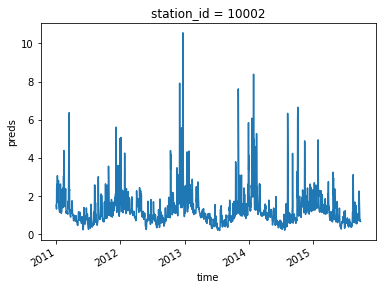

In [46]:
fig, ax = plt.subplots()
lstm_pred.preds.isel(station_id=0).plot(ax=ax)

# Read in the True data

In [47]:
# ds = xr.open_dataset(data_dir / 'interim__/camels_preprocessed/data.nc')
ds = xr.open_dataset(data_dir / 'interim/camels_preprocessed/data.nc')

# get the times that match
min_time = lstm_pred.time.min().values
max_time = lstm_pred.time.max().values
y_test = ds.discharge_spec.sel(time=slice(min_time, max_time))

In [48]:
y_test

<xarray.DataArray 'discharge_spec' (time: 1734, station_id: 671)>
[1163514 values with dtype=float64]
Coordinates:
  * station_id  (station_id) object '55008' '54027' '102001' ... '54095' '97002'
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

In [49]:
# get the stations that match
y_test = y_test.sel(
    station_id=y_test.station_id[
        np.isin(y_test.station_id, lstm_pred.station_id)
    ]
)

In [50]:
y_test

<xarray.DataArray 'discharge_spec' (time: 1734, station_id: 662)>
[1147908 values with dtype=float64]
Coordinates:
  * station_id  (station_id) object '54027' '102001' '72005' ... '54095' '97002'
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

In [51]:
from src.analysis.evaluation import join_true_pred_da

In [52]:
true_da = y_test
pred_da = lstm_pred.preds

In [53]:
df = (
    join_true_pred_da(true_da, pred_da)
    .to_dataframe()
    .reset_index()
    .set_index('time')
)
df.head()

,station_id,discharge_spec,preds
time,,,
2011-01-01,10002,3.65,1.533815
2011-01-02,10002,2.76,1.513672
2011-01-03,10002,3.22,1.332925
2011-01-04,10002,3.32,2.429470
2011-01-05,10002,2.68,1.747459


# compare performance

In [54]:
from src.analysis.evaluation import (r2_score, rmse, spatial_rmse, spatial_r2, spatial_nse) 
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse

In [55]:
# calculate performance for each station (collapse time)
rmse_da = spatial_rmse(y_test, lstm_pred.preds)
r2_da = spatial_r2(y_test, lstm_pred.preds)
nse_da = spatial_nse(y_test, lstm_pred.preds)

In [56]:
# calculate performance for each station (collapse space)
rmse_time = temporal_rmse(y_test, lstm_pred.preds)
r2_time = temporal_r2(y_test, lstm_pred.preds)
nse_time = temporal_nse(y_test, lstm_pred.preds)

In [57]:
print(f"Mean Station RMSE: {rmse_da.mean().values:.2f}")
print(f"Mean Station NSE: {nse_da.mean().values:.2f}")
print(f"Mean Station R2: {r2_da.mean().values:.2f}")

print(f"\n\nMean Time RMSE: {rmse_time.mean().values:.2f}")
print(f"Mean Time NSE: {nse_time.mean().values:.2f}")
print(f"Mean Time R2: {r2_time.mean().values:.2f}")

Mean Station RMSE: 1.79
Mean Station NSE: 0.44
Mean Station R2: 0.65


Mean Time RMSE: 1.72
Mean Time NSE: 0.45
Mean Time R2: 0.53


In [58]:
# rmse and r2 df
metrics_df = rmse_da.to_dataframe().drop(columns='time').rename(columns={"preds": "rmse"}).join(
    r2_da.to_dataframe().drop(columns='time').rename(columns={"preds": "r2"})
)
metrics_df = metrics_df.join(
    nse_da.to_dataframe().rename(columns={"preds": "nse"})
)

metrics_df = metrics_df.reset_index()
metrics_df.head()

,station_id,rmse,r2,nse
0,10002,0.662272,0.743460,0.693054
1,10003,0.646173,0.686835,0.590225
2,1001,1.132193,0.690408,0.687070
3,101002,0.838269,0.606174,0.491369
4,101005,1.101507,0.529194,0.364561


In [60]:
# TEMPORAL rmse and r2 df
metrics_time = rmse_time.to_dataframe().rename(columns={"discharge_spec": "rmse"}).join(
    r2_time.to_dataframe().rename(columns={"discharge_spec": "r2"})
)
metrics_time = metrics_time.join(
    nse_time.to_dataframe().rename(columns={"discharge_spec": "nse"})
)

metrics_time = metrics_time.reset_index()
metrics_time['time'] = [pd.to_datetime(t) for t in metrics_time.time]
metrics_time.head()

,time,rmse,r2,nse
0,2011-01-01,1.159114,0.368103,0.354248
1,2011-01-02,0.657010,0.535782,0.524600
2,2011-01-03,1.064876,0.480394,0.476575
3,2011-01-04,2.264482,0.609919,0.607888
4,2011-01-05,1.552811,0.612158,0.582505


## Compare with Crooks and Martinez Stations
```
12002 - Dee @ Park1
15006 - Tay @ Ballathie1
27009 - Ouse @ Skelton1
27034 - Ure @ Kilgram1
27041 - Derwent @ Buttercrambe1
39001 - Thames @ Kingston1
39081 - Ock @ Abingdon1
43021 - Avon @ Knapp
47001 - Tamar @ Gunnislake1
54001 - Severn @ Bewdley1
54057 - Severn @ Haw
71001 - Ribble @ Samlesbury1
84013 - Clyde @ Daldowie1
```

In [61]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://upload.wikimedia.org/wikipedia/commons/c/c4/Gb4dot_rivers.svg", height=400, width=400)
# Image(url= "https://en.wikipedia.org/wiki/List_of_rivers_of_England#/media/File:Major.rivers.of.England.jpg", height=400, width=400)

In [66]:
def plot_station_scatter(
    df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None
):
    # select station
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    # plot scatter
    ax.plot(d[target_var], d.preds, 'kx', alpha=0.6, label='Data Point')
    # plot 1:1 line
    line_1_1_x = np.linspace(d[target_var].min(), d[target_var].max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')

    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None,
                station_name: Optional[str] = None):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    # plot the station
    df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

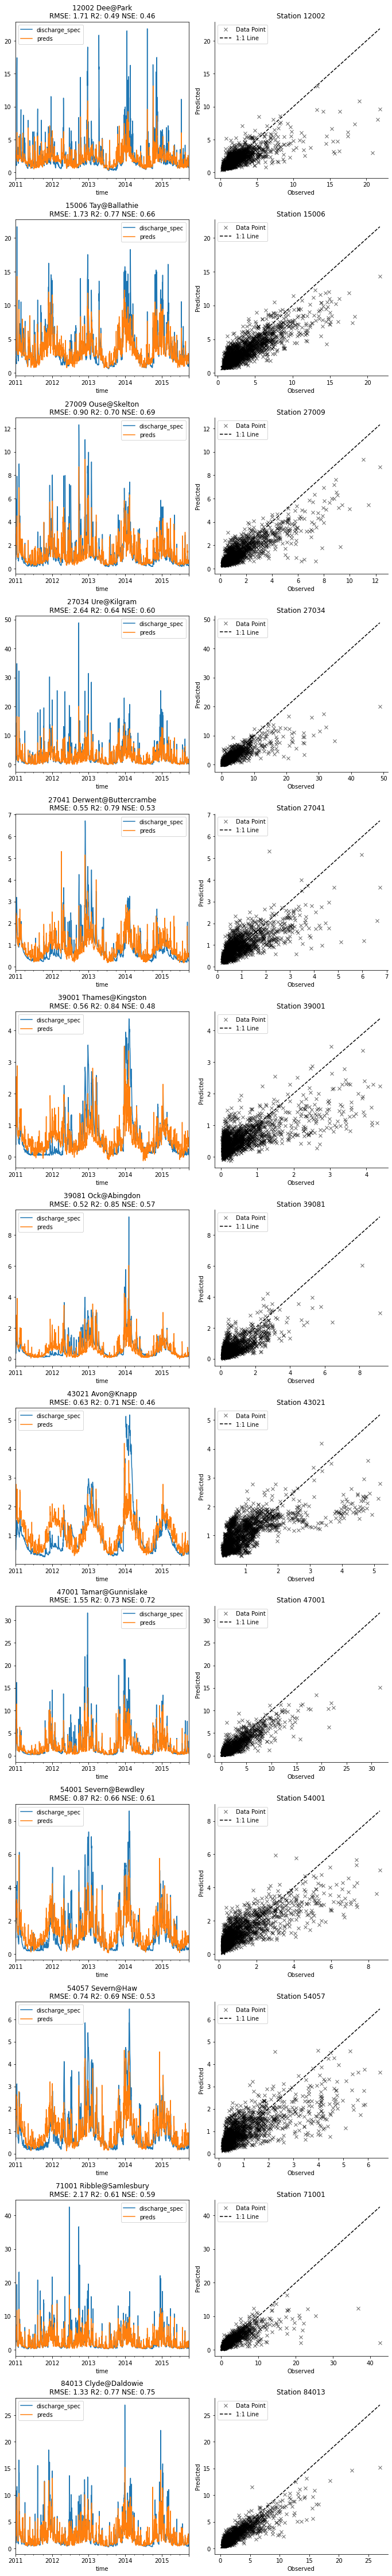

In [67]:
# test_stations = ['22007', '27049', '28018', '31021', '31023', '34004', '35003', '39022', '41029', '51001', '55025', '57004', '83010']
catchment_ids = ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

scale = 0.8
fig, axs = plt.subplots(13, 2, figsize=(12*scale, 6*scale*13))

for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
#     fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
    plot_station(df, station_id, metrics_df, ax=axs[ix, 0], station_name=station_name)
    plot_station_scatter(df, station_id, metrics_df, axs[ix, 1])
    plt.tight_layout()

# Scatterplot of different months
- scatterplots of observed vs pred data for different months

In [69]:
import calendar
from src.analysis.evaluation import _rmse_func, _r2_func, _nse_func


def calculate_error_metrics(df: pd.DataFrame, target_var: str = 'discharge_spec') -> Tuple[float, float, float]:
    """Calculate error metrics"""
    rmse = _rmse_func(df[target_var], df.preds, n_instances=df.shape[0])
    r2 = _r2_func(df[target_var], df.preds)
    nse = _nse_func(df[target_var], df.preds)
    return rmse, r2, nse


def plot_annual_scatters(
    df: pd.DataFrame, 
    suptitle: Optional[str] = None,
    target_var: str = 'discharge_spec',
):
    """For each month plot the scatter and the error metrics in the title"""
    month_strs = [m for m in calendar.month_abbr]
    
    # 4x3 grid for 12 months
    fig, axs = plt.subplots(4, 3, figsize=(15, 6*4)) # , sharex=True, sharey=True, 
    
    # for each month plot scatter 
    for mth in np.arange(1, 13):
        ax_ix = np.unravel_index(mth - 1, (4, 3))
        ax = axs[ax_ix]
        
        # select the data corresponding to that month
        d = df[df.index.month == mth]

        # get error metrics
        rmse, r2, nse = calculate_error_metrics(df=d, target_var=target_var)

        # create title
        title = f"{month_strs[mth]}\nRMSE: {rmse:.2f} R2: {r2:.2f} NSE: {nse:.2f}"

        # plot the scatter
        ax = plot_obs_pred_scatter(
            x=d[target_var],
            y=d.preds,
            ax=ax,
            title=title
        )
        
        # set the labels
        if ax_ix[0] == 3:
            ax.set_xlabel('Observed')
        if ax_ix[1] == 0:
            ax.set_ylabel('Predicted')
    
    if suptitle is not None:
        fig.tight_layout(rect=[0, 0.03, 1, 0.965])
        fig.suptitle(suptitle, size=16)
            
    return fig, ax

In [72]:
def plot_obs_pred_scatter(
    x: Union[pd.Series, np.array], 
    y: Union[pd.Series, np.array],
    ax: plt.Axes,
    title: str, 
) -> plt.Axes:
    """Scatter plot of x """
    ax.plot(x, y, 'kx', alpha=0.3, label='Data')

    # plot 1:1 line
    line_1_1_x = np.linspace(np.min(x), np.max(x), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')

    ax.set_title(title)
    ax.legend()
    
    return ax


def plot_all_data_annual_scatters(
    df: pd.DataFrame, 
    metrics_time: pd.DataFrame,
    suptitle: Optional[str] = None,
    target_var: str = 'discharge_spec',
):
    """For each month plot the scatter and the error metrics in the title"""
    month_strs = [m for m in calendar.month_abbr]
    
    # 4x3 grid for 12 months
    fig, axs = plt.subplots(4, 3, figsize=(15, 6*4)) # , sharex=True, sharey=True, 
    
    # for each month plot scatter 
    for mth in np.arange(1, 13):
        ax_ix = np.unravel_index(mth - 1, (4, 3))
        ax = axs[ax_ix]
        
        # select the data corresponding to that month
        d = df[df.index.month == mth]

        # get error metrics
        mean_metrics = metrics_time[metrics_time.time.dt.month == mth].mean()
        rmse = mean_metrics.loc['rmse']
        nse = mean_metrics.loc['nse']
        r2 = mean_metrics.loc['r2']

        # create title
        title = f"{month_strs[mth]}\nRMSE: {rmse:.2f} R2: {r2:.2f} NSE: {nse:.2f}"

        # plot the scatter
        ax = plot_obs_pred_scatter(
            x=d[target_var],
            y=d.preds,
            ax=ax,
            title=title
        )
        
        # set the labels
        if ax_ix[0] == 3:
            ax.set_xlabel('Observed')
        if ax_ix[1] == 0:
            ax.set_ylabel('Predicted')
    
    if suptitle is not None:
        fig.tight_layout(rect=[0, 0.03, 1, 0.965])
        fig.suptitle(suptitle, size=16)
            
    return fig, ax

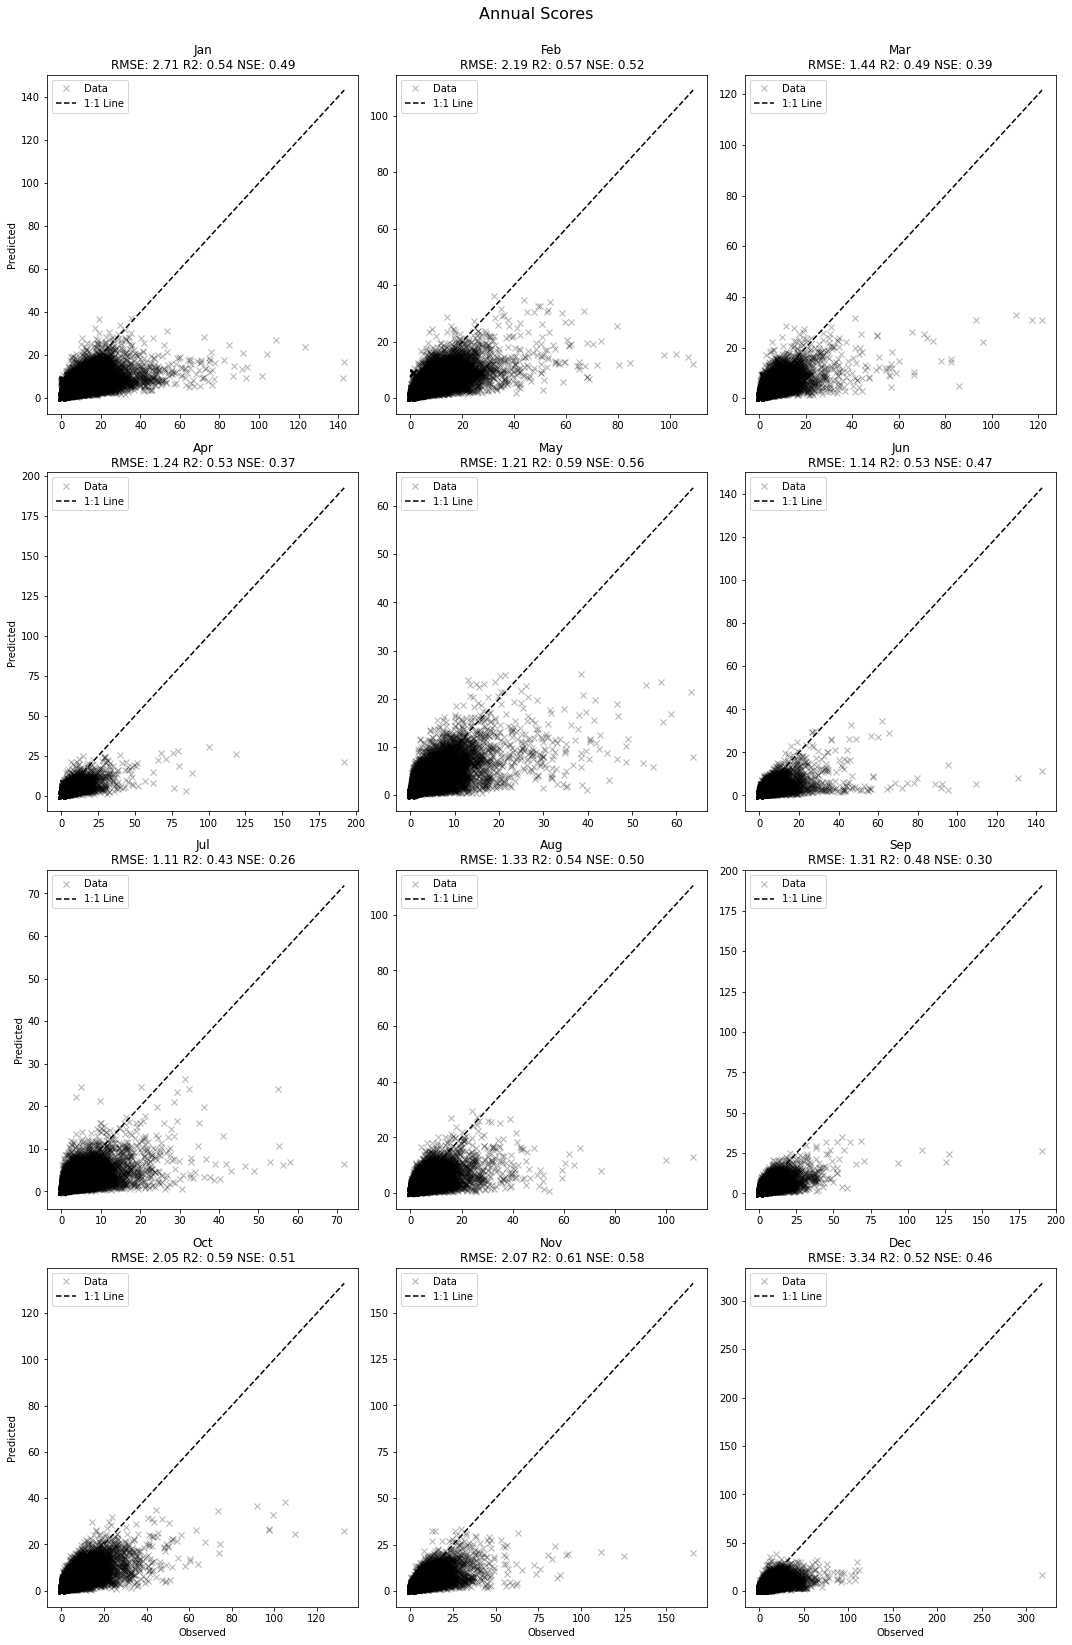

In [73]:
plot_all_data_annual_scatters(
    df, metrics_time, target_var='discharge_spec', suptitle='Annual Scores'
);

### Plot annual scatters for individual Station

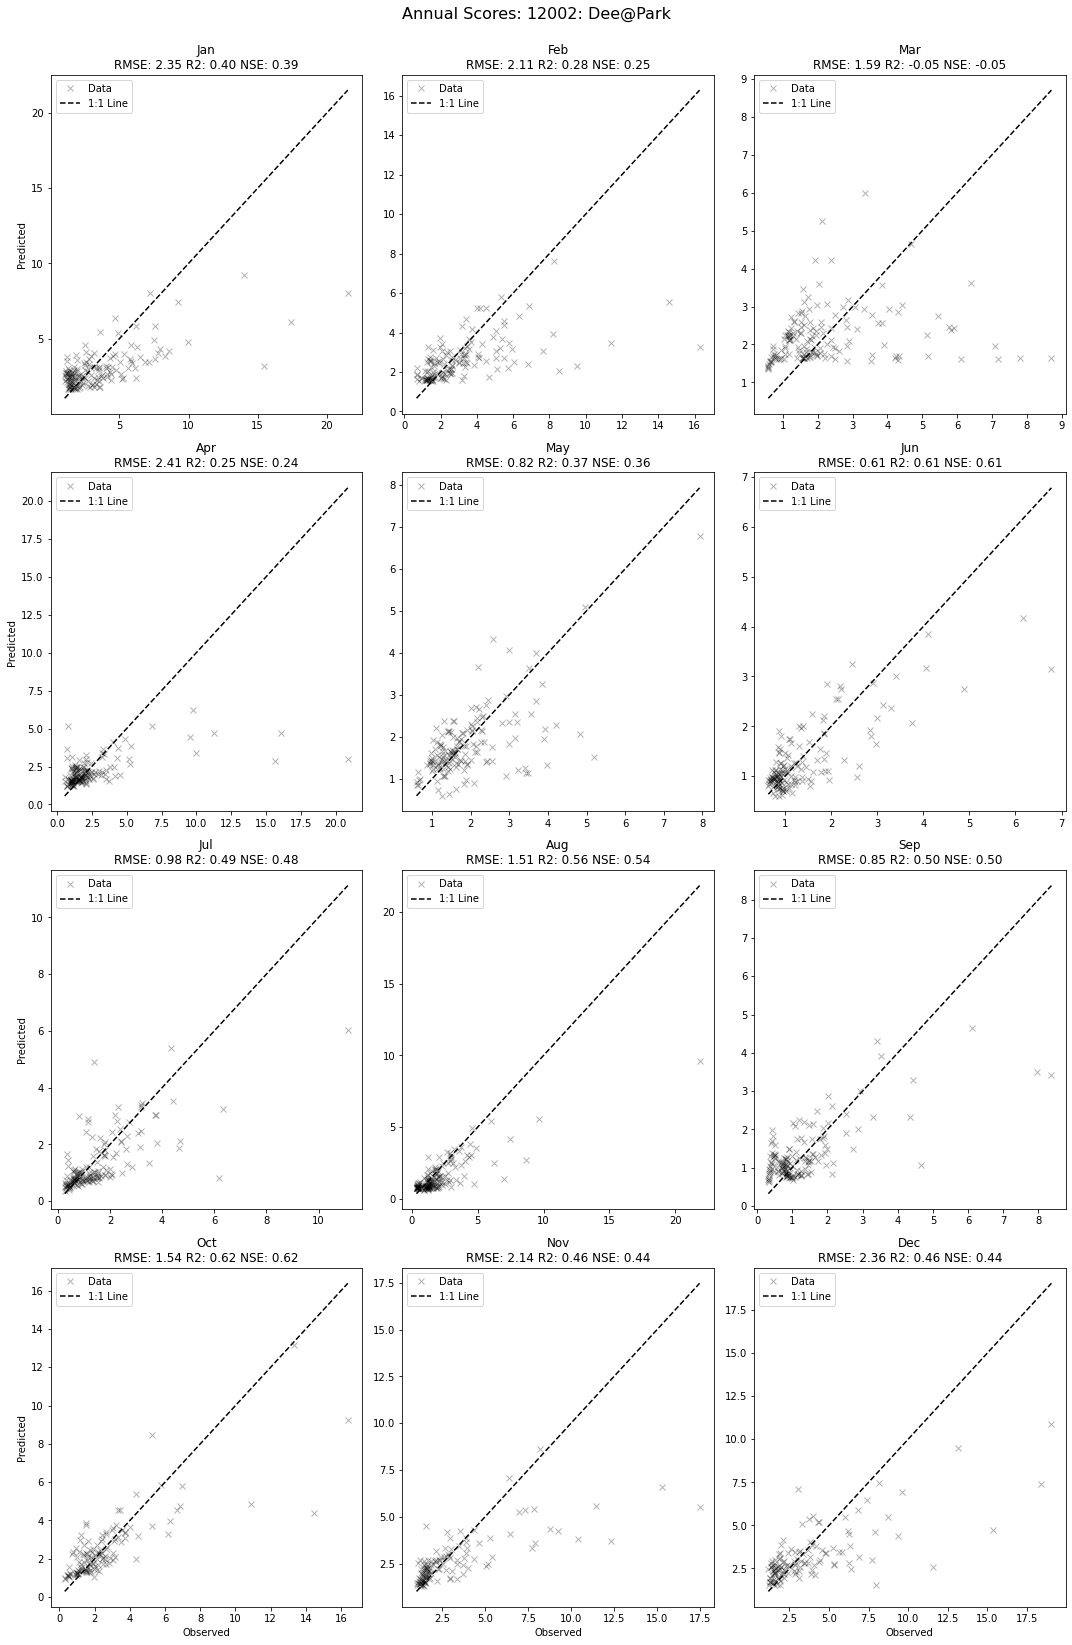

In [80]:
station_map = dict(zip(catchment_ids, catchment_names))

for station_id in catchment_ids:
    station_name = station_map[station_id]
    suptitle = f'Annual Scores: {station_id}: {station_name}'

    d = df.query(f'station_id == "{station_id}"')
    try:
        plot_annual_scatters(d, suptitle);
    except ValueError:
        print(f"ERROR: {suptitle}")
    
    break

# Plot on a map

In [81]:
import geopandas as gpd

gdf_path = Path('/home/jovyan/runoff_uk_lstm/data/CAMELS/CAMELS_GB_DATASET/Catchment_Boundaries')
[d.name for d in gdf_path.iterdir()]

['CAMELS_GB_catchment_boundaries.shp.xml',
 'CAMELS_GB_catchment_boundaries.sbn',
 'CAMELS_GB_catchment_boundaries.prj',
 'CAMELS_GB_catchment_boundaries.shp',
 'CAMELS_GB_catchment_boundaries.cpg',
 'CAMELS_GB_catchment_boundaries.shx',
 'CAMELS_GB_catchment_boundaries.sbx',
 'CAMELS_GB_catchment_boundaries.dbf']

In [82]:
gdf = gpd.read_file(gdf_path / 'CAMELS_GB_catchment_boundaries.shp')
gdf.head()

,ID_STRING,ID,SOURCE,VERSION,EXPORTED,geometry
0,10002,10002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((410125.0000999998 848525.0000999998,..."
1,10003,10003.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((394725.0000999998 830350.0000999998,..."
2,1001,1001.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((326225.0000999998 954900.0000999998,..."
3,101002,101002.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((450375.0000999998 88125.00009999983,..."
4,101005,101005.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((453125.0000999998 83525.00009999983,..."


### Plot the 13 basins 

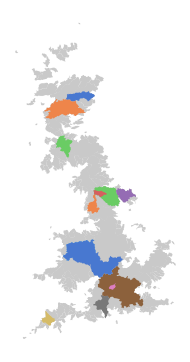

In [83]:
def highlight_basin(basin_ids: List[str], scale: float = 0.9, colors: Optional[List[str]] = None) -> None:
    """Plot all the basins in `gdf`"""
    fig, ax = plt.subplots(figsize=(12*scale, 8*scale))
    gdf.plot(ax=ax, color='#c9c9c9')
    
    for ix, basin_id in enumerate(basin_ids):
        if colors is None:
            gdf.query(f"ID_STRING == '{basin_id}'").plot(ax=ax)
        else:
            color = colors[ix]
            gdf.query(f"ID_STRING == '{basin_id}'").plot(ax=ax, color=color)
    ax.axis('off');


highlight_basin(catchment_ids, scale=0.8, colors=sns.color_palette('muted', len(catchment_ids) + 1))

In [84]:
lookup_gdf = gdf[['ID_STRING', 'geometry']]

In [85]:
metrics_df.head()

,station_id,rmse,r2,nse
0,10002,0.662272,0.743460,0.693054
1,10003,0.646173,0.686835,0.590225
2,1001,1.132193,0.690408,0.687070
3,101002,0.838269,0.606174,0.491369
4,101005,1.101507,0.529194,0.364561


### Error Metrics over Space
colorbar issues in geopandas:
- https://github.com/geopandas/geopandas/pull/894
- https://stackoverflow.com/questions/53158096/editing-colorbar-legend-in-geopandas
- [Create for yourself](https://stackoverflow.com/a/51890764/9940782)

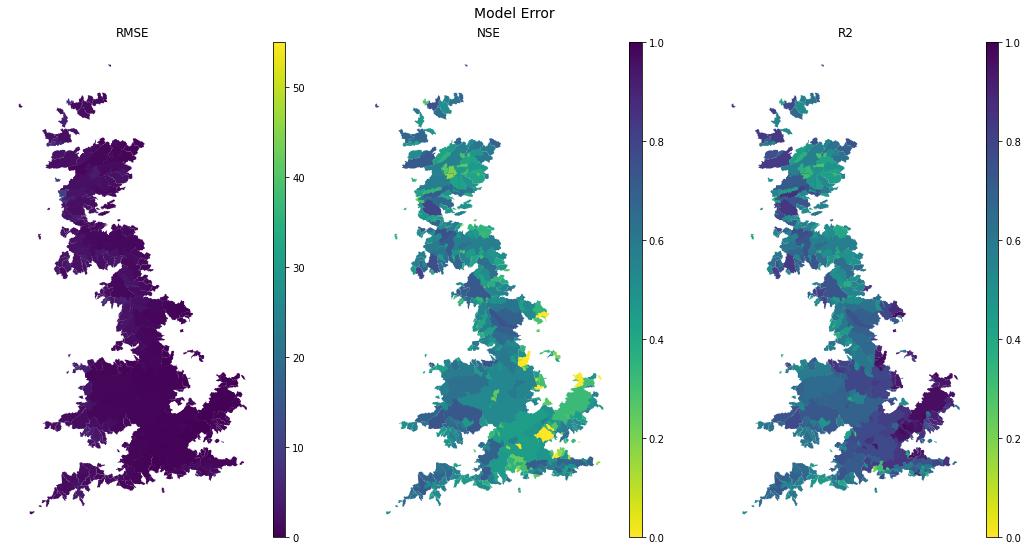

In [86]:
# create spatial dataframe
metrics_gdf = gpd.GeoDataFrame(
    lookup_gdf.set_index('ID_STRING').join(metrics_df.set_index('station_id'))
)


from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
opts = [
    {"vmin": 0, "vmax":55, 'cmap': 'viridis'},   # rmse   
    {"vmin": 0, "vmax":1, 'cmap': 'viridis_r'},    # nse   
    {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'}    # r2  
]

for ix, metric in enumerate(["rmse", "nse", "r2"]):
    ax = axs[ix]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs

    # legend_kwargs = {'label': metric.upper(), 'orientation': 'horizontal'}
    metrics_gdf.plot(
        column=metric, ax=ax, 
        cmap=opts[ix]['cmap'],legend=True, cax=cax,
        vmin=opts[ix]['vmin'], vmax=opts[ix]['vmax'],
    )  #, legend_kwds=legend_kwargs)

    ax.set_title(f'{metric.upper()}')

    ax.axis('off');

fig.tight_layout(rect=[0, 0.03, 1, 0.965])
fig.suptitle("Model Error", size=14);

# Focus more attention on the worst performing stations

### Top 10 stations

In [87]:
# rmse_da; nse_da; r2_da
def get_n_hilo_values(da: xr.DataArray, n_values: int, hilo: str = 'high', coord: Optional[str] = None) -> xr.DataArray:
    assert hilo in ['high', 'low'], "only high / low are valid options for top/bottom n"

    coord = [c for c in da.coords][0] if coord is None else coord
    sorted_da = da.sortby(da).where(~da.isnull(), drop=True)
    if hilo == 'low':
        return sorted_da.isel({coord: slice(0, n_values)})
    elif hilo == 'high':
        return sorted_da.isel({coord: np.arange(-n_values, 0)})
    else:
        assert False
    
top_10 = get_n_hilo_values(nse_da, 10, hilo='high')
bottom_10 = get_n_hilo_values(nse_da, 10, hilo='low')

### Dynamic and Static Data

In [88]:
from src.models import load_model

lstm = load_model(data_dir / f"models/{EXPERIMENT}/rnn/model.pt")

In [89]:
# Dynamic data
print(lstm.ignore_vars)
dynamic_ds = ds.drop(lstm.ignore_vars)
dynamic_ds

['temperature', 'discharge_vol', 'discharge_spec', 'peti', 'humidity', 'shortwave_rad', 'longwave_rad', 'windspeed']


<xarray.Dataset>
Dimensions:        (station_id: 671, time: 16436)
Coordinates:
  * station_id     (station_id) object '55008' '54027' ... '54095' '97002'
  * time           (time) datetime64[ns] 1970-10-01 1970-10-02 ... 2015-09-30
Data variables:
    precipitation  (time, station_id) float64 ...
    pet            (time, station_id) float64 ...

In [90]:
# static data
dl = lstm.get_dataloader(mode='train')
train_iter = iter(dl)
static_ds = train_iter.static
# [v for v in static_ds.data_vars]

In [91]:
dynamic_ds

<xarray.Dataset>
Dimensions:        (station_id: 671, time: 16436)
Coordinates:
  * station_id     (station_id) object '55008' '54027' ... '54095' '97002'
  * time           (time) datetime64[ns] 1970-10-01 1970-10-02 ... 2015-09-30
Data variables:
    precipitation  (time, station_id) float64 ...
    pet            (time, station_id) float64 ...

### Plot the dynamic variables on a map

In [103]:
mean_dynamic_df = dynamic_ds.mean(dim='time').to_dataframe()
mean_target_df = ds[TARGET_VAR].mean(dim='time').to_dataframe()
mean_dynamic_df = mean_dynamic_df.join(mean_target_df, lsuffix='1')

dynamic_gdf = gpd.GeoDataFrame(
    lookup_gdf.set_index('ID_STRING').join(mean_dynamic_df)
)
dynamic_gdf.head()

,geometry,precipitation,pet,discharge_spec
ID_STRING,,,,
10002,"POLYGON ((410125.0000999998 848525.0000999998,...",2.285046,1.264496,1.300733
10003,"POLYGON ((394725.0000999998 830350.0000999998,...",2.306687,1.252474,1.328562
1001,"POLYGON ((326225.0000999998 954900.0000999998,...",2.645004,1.153983,1.663329
101002,"POLYGON ((450375.0000999998 88125.00009999983,...",2.308680,1.452608,0.875331
101005,"POLYGON ((453125.0000999998 83525.00009999983,...",2.294397,1.448397,0.795439


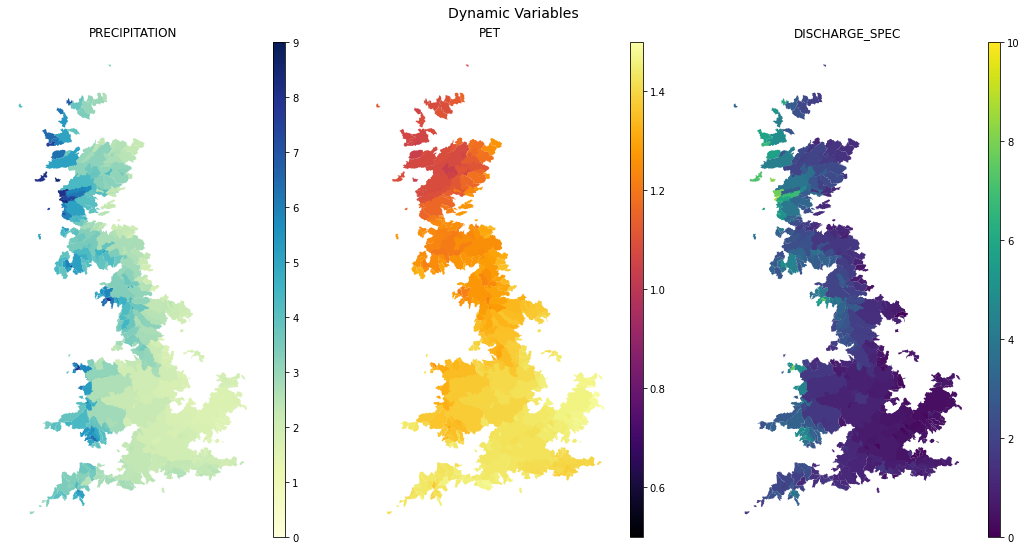

In [105]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
opts = [
    {"vmin": 0, "vmax": 9, 'cmap': 'YlGnBu'},   # precip   
    {"vmin": 0.5, "vmax": 1.5, 'cmap': 'inferno'},    # pet   
    {"vmin": 0, "vmax": 8, 'cmap': 'viridis'}    # target_Var  
]

for ix, variable in enumerate(["precipitation", "pet", TARGET_VAR]):
    ax = axs[ix]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs

    dynamic_gdf.plot(
        column=variable, ax=ax, 
        legend=True, cax=cax,
        vmin=opts[ix]['vmin'], vmax=opts[ix]['vmax'], cmap=opts[ix]['cmap']
    )

    ax.set_title(f'{variable.upper()}')

    ax.axis('off');

fig.tight_layout(rect=[0, 0.03, 1, 0.965])
fig.suptitle("Dynamic Variables", size=14);

### Which static variables correlate with rmse / r2 ?

In [ ]:
# !pip install git+https://github.com/hrishikeshac/mvstats.git

In [ ]:
# import mvstats.mvstats as mv

In [106]:
def get_corresponding_stations(static_ds: xr.Dataset, metric_da: xr.DataArray) -> Tuple[xr.DataArray, xr.Dataset]:
    # sortby the station_ids so they correspond to one another
    metric_da['station_id'] = metric_da.station_id.astype(int)
    metric_da = metric_da.sortby('station_id')
    static_ds = static_ds.sortby('station_id')

    # get the same station_ids
    static_d = static_ds.sel(station_id=static_ds.station_id.values[np.isin(static_ds.station_id.values, metric_da.station_id.values)])
    metric_da = metric_da.sel(station_id=metric_da.station_id.values[np.isin(metric_da.station_id.values, static_ds.station_id.values)])

    # ensure stations the same
    assert metric_da.shape == static_d[[v for v in static_d.data_vars][0]].shape
    
    return metric_da, static_d


def calculate_static_corr(static_ds: xr.Dataset, metric_da: xr.DataArray) -> pd.DataFrame:
    metric_da, static_ds = get_corresponding_stations(static_ds, metric_da)

    # calculate correlations (np.corrcoef) for each static_var
    static_corr_dict = {}
    for static_var in [v for v in static_ds.data_vars]:
        static_corr_dict[static_var] = np.corrcoef(metric_da.values, static_ds[static_var].values)[0, 1]
    
    # create dataframe
    static_corr_df = (
        pd.DataFrame(static_corr_dict, index=[0])
        .T.reset_index()
        .rename(columns={'index': 'variable', 0: 'value'})
        .sort_values("value")
        .dropna()
    )
    
    return static_corr_df

# # sortby the station_ids so they correspond to one another
# rmse_da['station_id'] = rmse_da.station_id.astype(int)
# rmse_da = rmse_da.sortby('station_id')
# static_ds = static_ds.sortby('station_id')

# # get the same station_ids
# static_d = static_ds.sel(station_id=static_ds.station_id.values[np.isin(static_ds.station_id.values, rmse_da.station_id.values)])
# rmse_d = rmse_da.sel(station_id=rmse_da.station_id.values[np.isin(rmse_da.station_id.values, static_ds.station_id.values)])

# # ensure stations the same
# assert rmse_d.shape == static_d[[v for v in static_d.data_vars][0]].shape

In [107]:
static_corr_df_rmse = calculate_static_corr(static_ds, rmse_da)
static_corr_df_r2 = calculate_static_corr(static_ds, r2_da)
static_corr_df_r2.head()

,variable,value
69,runoff_ratio,-0.492145
17,elev_50,-0.441663
16,elev_10,-0.426318
18,elev_90,-0.419649
76,Q95,-0.395718


#### NOTE: the graphs should be interpreted as such:
- positive values mean that when the static variable is large the error is large
- negative values mean that when the static variable is small the error is small
- Is this really what we want to show ??
- I want to show the spatial distribution of error and didn't know how to plot all 100 
e.g. When there is a **high precipitation frequency** (lots of rainfall events) the error is small. So our models perform better in stations where there is lots of rainfall


e.g. **Area** is positively correlated with RMSE. NOTE: this is an artefact because the RMSE values are larger in larger catchments because RMSE is measured in discharge_volume (m3/s). 


e.g. **Aridity** is positively correlated with R2, so we do better in higher aridity basins (drier basins) (NOTE: does this make sense when we look at arid basins we look like we do worse no ?)


e.g. **p_mean** the higher mean precipitation the lower the R2 (bigger error). 

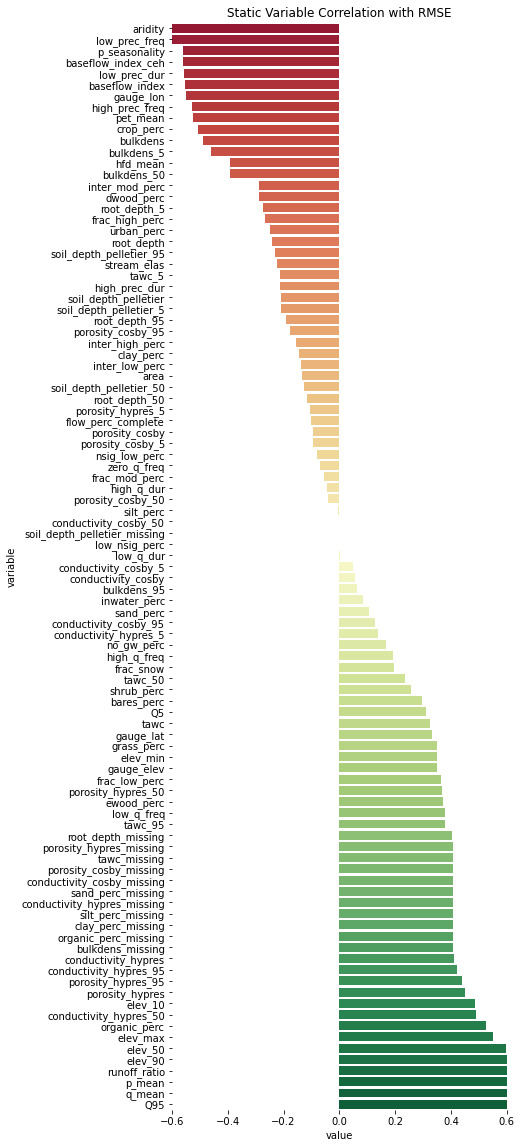

In [113]:
fig, ax = plt.subplots(figsize=(6, 20))

# sns.set_color_codes()
sns.barplot(x="value", y="variable", data=static_corr_df_rmse, ax=ax, palette='RdYlGn')
sns.despine(left=True, bottom=True);
ax.set_title('Static Variable Correlation with RMSE');
ax.set_xlim(-0.6, 0.6);

In [ ]:
fig, ax = plt.subplots(figsize=(6, 20))
sns.barplot(x="value", y="variable", data=static_corr_df_r2, ax=ax, palette='RdYlGn')
sns.despine(left=True, bottom=True);
ax.set_title('Static Variable Correlation with R2');
ax.set_xlim(-0.65, 0.65);

### normalise the RMSE by mean discharge
NOTE: already done if `TARGET_VAR == 'discharge_spec'`

In [ ]:
dynamic_ds['station_id'] = dynamic_ds.station_id.astype(int)

In [ ]:
if TARGET_VAR != "discharge_spec":

    # create spatial dataframe
    assert rmse_da.station_id.dtype == dynamic_ds.station_id.dtype, (
        f"rmse_da: {rmse_da.station_id.dtype} dynamic_ds: {dynamic_ds.station_id.dtype}"
    )
    norm_rmse_df = (
        (rmse_da / dynamic_ds['discharge_vol'].mean(dim='time'))
        .to_dataframe(name='rmse')
        .drop(columns='time')
        .reset_index()
        .astype({'station_id': str})
        .set_index('station_id')
    )

    norm_rmse_gdf = gpd.GeoDataFrame(
        lookup_gdf.set_index('ID_STRING').join(norm_rmse_df).dropna()
    )

    norm_rmse_gdf.head()

In [ ]:
if TARGET_VAR != "discharge_spec":
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, ax = plt.subplots(figsize=(15/3, 8))

    opts = {"vmin": 0, "vmax":2.5, 'cmap': 'viridis'}

    metric = 'rmse'
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)

    norm_rmse_gdf.plot(
        column=metric, ax=ax, 
        cmap=opts['cmap'],legend=True, cax=cax,
        vmin=opts['vmin'], vmax=opts['vmax'],
    ) 

    ax.set_title(f'{metric.upper()} normalised by Mean Discharge')

    ax.axis('off');

In [108]:
if TARGET_VAR != "discharge_spec":
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    opts = [
        {"vmin": 0, "vmax":2.5, 'cmap': 'viridis'},   # rmse   
        {"vmin": 0, "vmax":1, 'cmap': 'viridis_r'},    # nse   
        {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'}    # r2  
    ]

    for ix, metric in enumerate(["rmse", "nse", "r2"]):
        ax = axs[ix]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs

        # legend_kwargs = {'label': metric.upper(), 'orientation': 'horizontal'}
        if metric == 'rmse':
            norm_rmse_gdf.plot(
                column=metric, ax=ax, 
                cmap=opts[ix]['cmap'],legend=True, cax=cax,
                vmin=opts[ix]['vmin'], vmax=opts[ix]['vmax'],
            ) 

            ax.set_title(f'{metric.upper()} normalised by Mean Discharge')

        else:
            metrics_gdf.plot(
                column=metric, ax=ax, 
                cmap=opts[ix]['cmap'],legend=True, cax=cax,
                vmin=opts[ix]['vmin'], vmax=opts[ix]['vmax'],
            )  #, legend_kwds=legend_kwargs)

            ax.set_title(f'{metric.upper()}')

        ax.axis('off');

    fig.tight_layout(rect=[0, 0.03, 1, 0.965])
    fig.suptitle("Model Error", size=14);

In [110]:
if TARGET_VAR != "discharge_spec":
    assert rmse_da.station_id.dtype == static_ds.station_id.dtype

    static_corr_df_rmse_norm = calculate_static_corr(static_ds, (rmse_da / dynamic_ds['discharge_vol'].mean(dim='time')))

In [109]:
if TARGET_VAR != "discharge_spec":
    fig, ax = plt.subplots(figsize=(6, 20))
    sns.barplot(x="value", y="variable", data=static_corr_df_rmse_norm, ax=ax, palette='RdYlGn')
    sns.despine(left=True, bottom=True);
    ax.set_title('Static Variable Correlation with RMSE normalised by mean discharge');
    ax.set_xlim(-0.65, 0.65);

# TODO:
- how to enforce a hard zero on predictions
- e.g. station 31023
- still missing the peaks of the distribution !!
- something to do with baseflow (?)

## Plot the top/bottom 10 stations

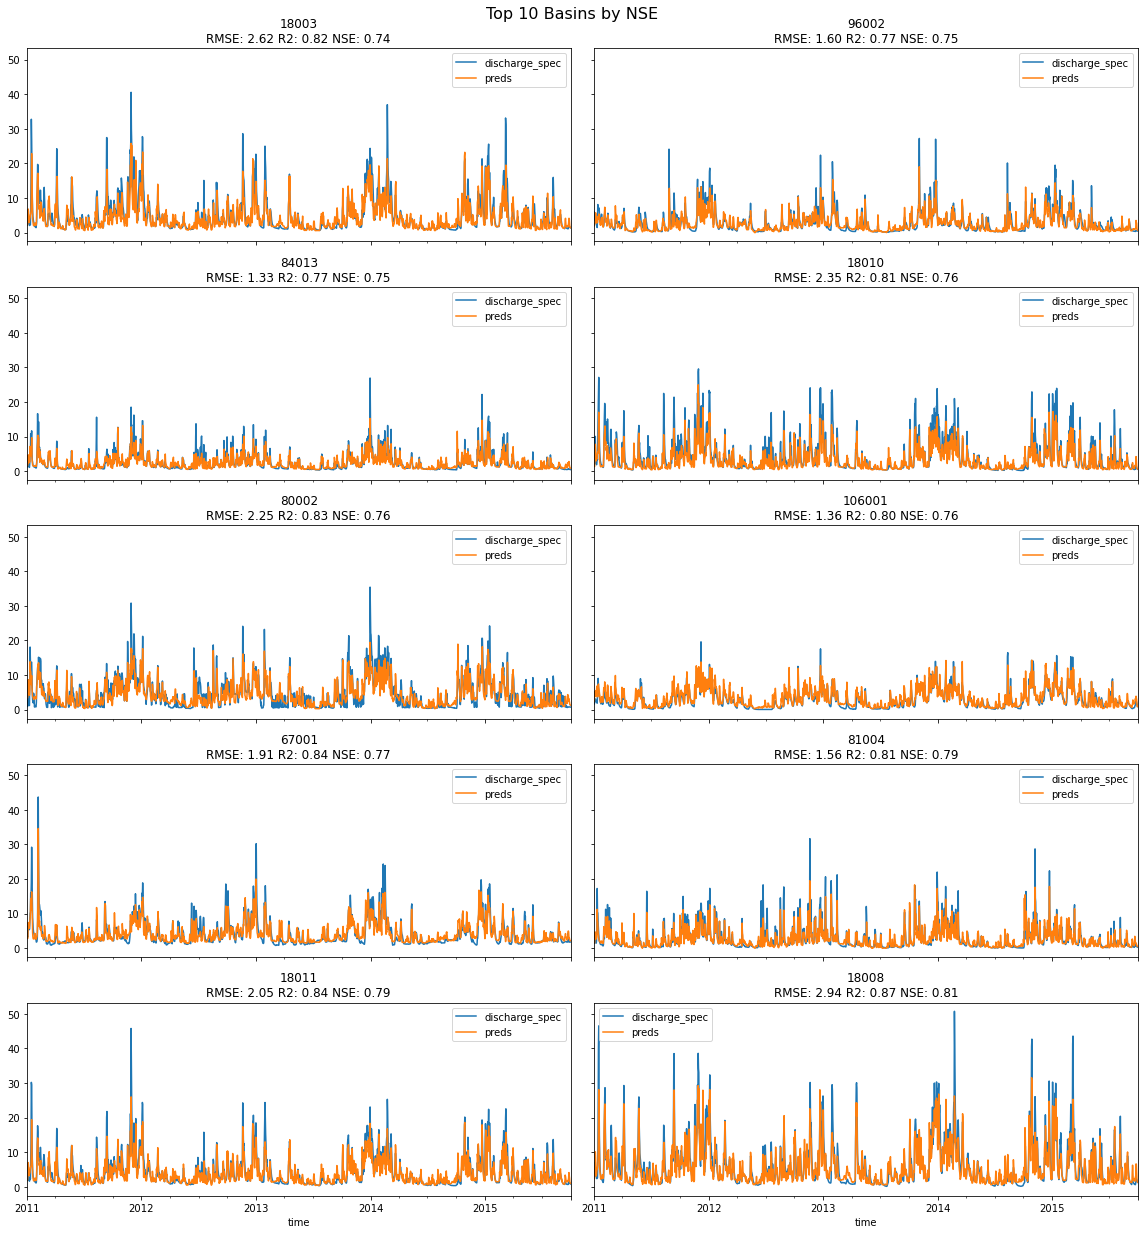

In [111]:
fig, axs = plt.subplots(5, 2, figsize=(16, 18), sharex=True, sharey=True)

for ix, station_id in enumerate(top_10.station_id.values):
    ax = axs[np.unravel_index(ix, (5, 2))]
    plot_station(df, station_id=station_id, metrics_df=metrics_df, ax=ax)

fig.suptitle('Top 10 Basins by NSE', y=0.98, size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

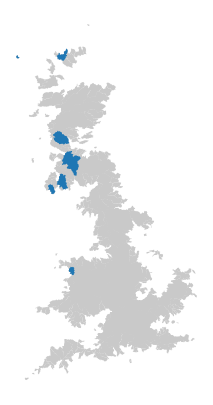

In [127]:
highlight_basin(
    top_10.station_id.values
)

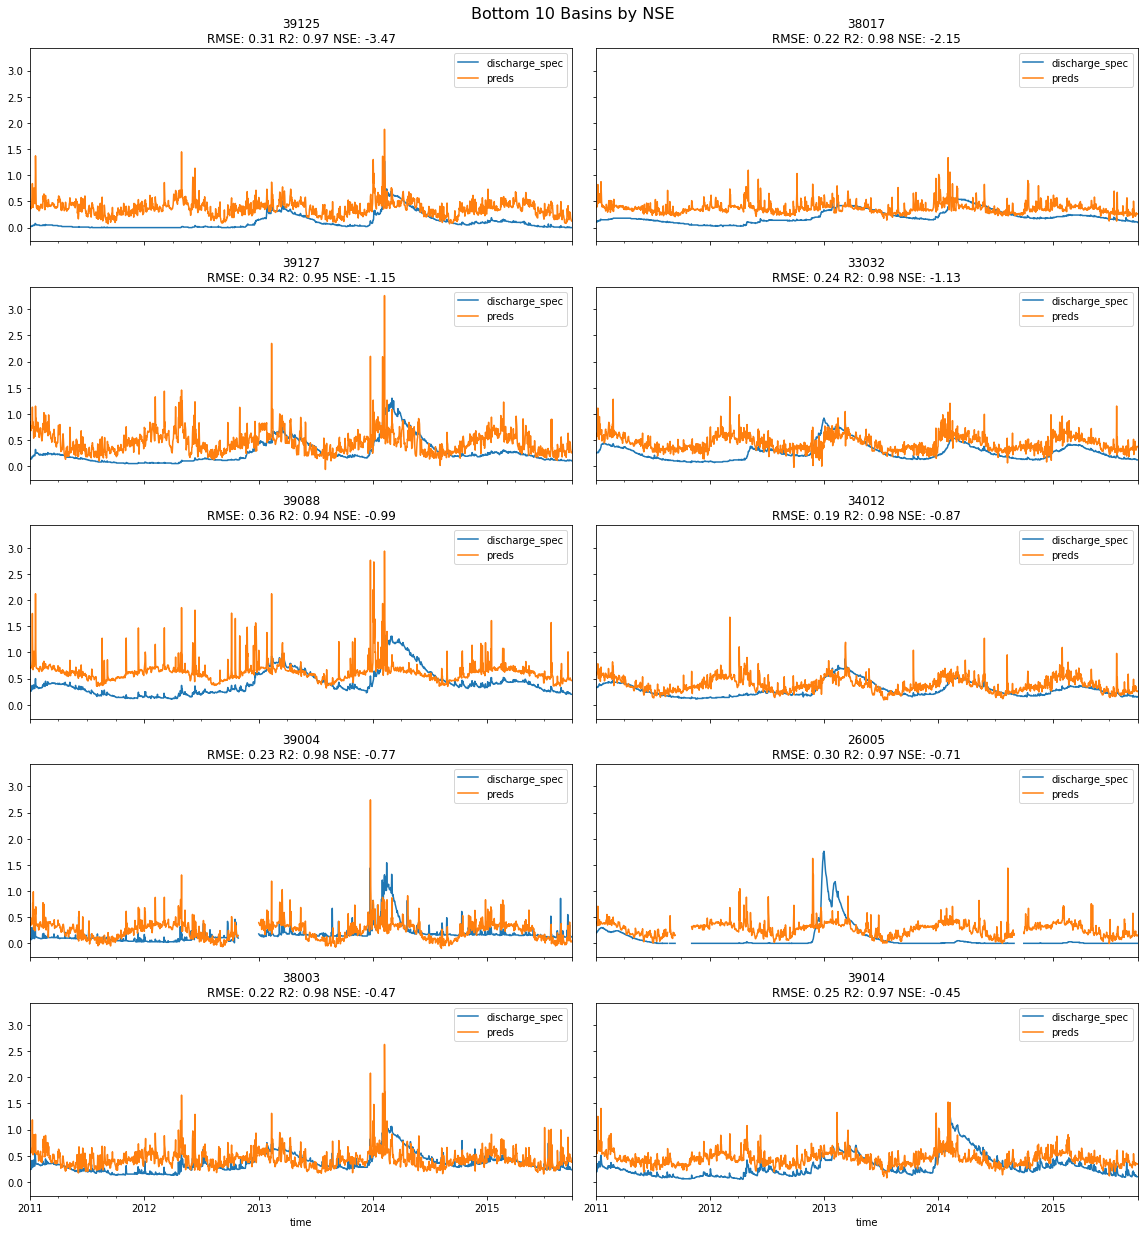

In [112]:
fig, axs = plt.subplots(5, 2, figsize=(16, 18), sharex=True, sharey=True)

for ix, station_id in enumerate(bottom_10.station_id.values):
    ax = axs[np.unravel_index(ix, (5, 2))]
    plot_station(df, station_id=station_id, metrics_df=metrics_df, ax=ax)

fig.suptitle('Bottom 10 Basins by NSE', y=0.98, size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

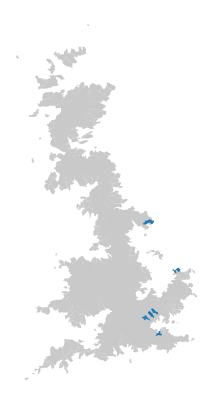

In [128]:
highlight_basin(
    bottom_10.station_id.values
)

# What data was used for training?

## look at the static data

In [129]:
from src.models import load_model

lstm = load_model(data_dir / f"models/{EXPERIMENT}/rnn/model.pt")

In [130]:
dl = lstm.get_dataloader(mode='train')
train_iter = iter(dl)
static_ds = train_iter.static
# [v for v in static_ds.data_vars]

In [131]:
# static_ds

### Extract features for top10 / bottom10

In [132]:
def get_station_data(ds: xr.Dataset, station_ids: List[int]) -> xr.Dataset:
    return ds.sel(station_id=np.isin(ds.station_id.values, station_ids))

In [133]:
# static_ds.sel(station_id=)

# static_ds.loc[dict(station_id=np.isin(static_ds.station_id.values, bottom_10.station_id.values.astype(int)))]

# static_ds.sel(station_id=np.isin(static_ds.station_id.values, bottom_10.station_id.values.astype(int)))

static_bottom = get_station_data(static_ds, bottom_10.station_id.values.astype(int))
dynamic_bottom = get_station_data(ds.drop(lstm.ignore_vars), bottom_10.station_id.values.astype(int))
static_top = get_station_data(static_ds, top_10.station_id.values.astype(int))
dynamic_top = get_station_data(ds.drop(lstm.ignore_vars), top_10.station_id.values.astype(int))

In [134]:
# static_top.mean().to_dataframe()

def convert_mean_vals_to_dataframe(ds) -> pd.DataFrame:
    data_dict = {}
    for k in ds.mean().to_dict()['data_vars'].keys():
        data = ds.mean().to_dict()['data_vars'][k]['data']
        data_dict[k] = data

    return pd.DataFrame(data_dict, index=[0]).melt()


def get_top_bottom_df(top_ds, bottom_ds) -> pd.DataFrame:
    df1 = convert_mean_vals_to_dataframe(bottom_ds).rename(columns={'value': 'bottom 10'}).set_index('variable')
    df2 = convert_mean_vals_to_dataframe(top_ds).rename(columns={'value': 'top 10'}).set_index('variable')
    return df1.join(df2)

df_static = get_top_bottom_df(top_ds=static_top, bottom_ds=static_bottom)
df_static.head()

,bottom 10,top 10
variable,,
inter_high_perc,0.006,0.000
inter_mod_perc,15.235,9.607
inter_low_perc,0.379,0.000
frac_high_perc,31.809,0.005
frac_mod_perc,0.000,1.437


In [135]:
df_static['bottom 10'] - df_static['top 10']

variable
inter_high_perc        0.006
inter_mod_perc         5.628
inter_low_perc         0.379
frac_high_perc        31.804
frac_mod_perc         -1.437
                       ...  
crop_perc             52.576
urban_perc            10.536
inwater_perc          -2.951
bares_perc            -0.329
flow_perc_complete     3.444
Length: 100, dtype: float64

In [136]:
# NORMALIZE
df_static['bottom 10'] = df_static['bottom 10'] / df_static.max(axis=1)
df_static['top 10'] = df_static['top 10'] / df_static.max(axis=1)
df_static['diff'] = abs(df_static['bottom 10'] - df_static['top 10'])
df_static = df_static.sort_values('diff')
df_static.tail()

,bottom 10,top 10,diff
variable,,,
frac_mod_perc,0.0,1.000,1.000
inter_low_perc,1.0,0.000,1.000
inter_high_perc,1.0,0.000,1.000
p_seasonality,1.0,-0.267,1.267
gauge_lon,1.0,-4.322,5.322


In [138]:
d = df_static.reset_index().melt(id_vars=["variable"], var_name='type')

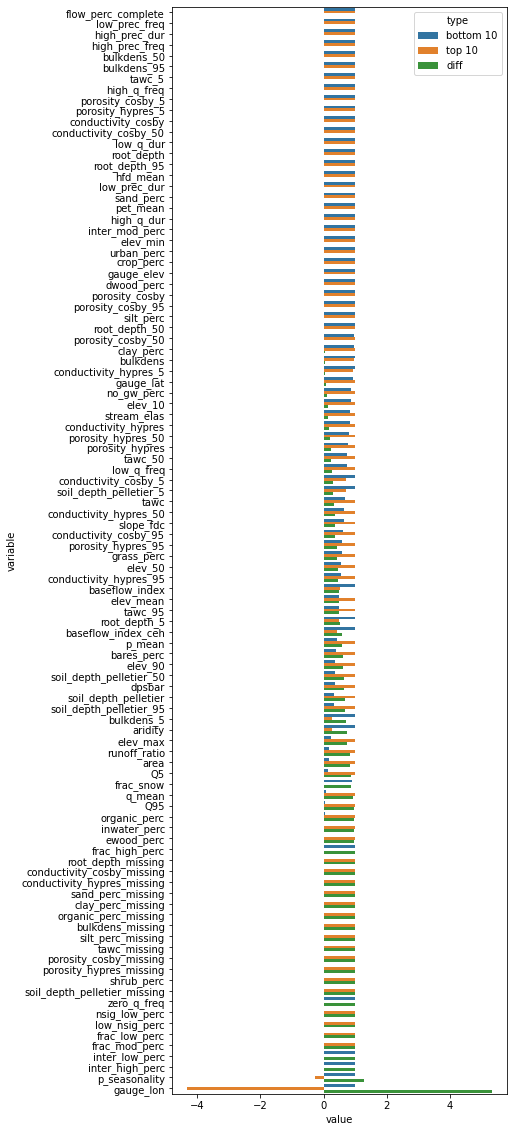

In [139]:
fig, ax = plt.subplots(figsize=(6, 20))
sns.barplot(x="value", y="variable", hue='type', data=d)

In [140]:
# df_dynamic = get_top_bottom_df(top_ds=dynamic_top.load(), bottom_ds=dynamic_bottom.load())

## And the Dynamic data?

# What about all of the models with NSE below 0

In [141]:
def get_station_data_pandas(df: pd.DataFrame, station_ids: List[str]) -> pd.DataFrame:
    station_ids = [str(s) for s in station_ids]
    return df.loc[np.isin(df.station_id, station_ids)]

In [142]:
# get all negative NSE basins
negative_nse = nse_da.where(nse_da < 0, drop=True)
ds_neg_nse = get_station_data(ds, negative_nse.station_id.values)
df_neg_nse = get_station_data_pandas(df, negative_nse.station_id.values)
static_neg_nse = get_station_data(static_ds, [int(s) for s in negative_nse.station_id.values])

# how many negatives? - get the N top basins to compare
top_n_nse = get_n_hilo_values(nse_da, len(ds_neg_nse.station_id), hilo='high')
ds_pos_nse = get_station_data(ds, top_n_nse.station_id.values)
df_pos_nse = get_station_data_pandas(df, top_n_nse.station_id.values)
static_pos_nse = get_station_data(static_ds, [int(s) for s in top_n_nse.station_id.values])

In [143]:
print(f"HOW MANY BASINS COMPARING: {len(ds_neg_nse.station_id)}\n")
display("DataFrame", df_neg_nse.head())
display("Dynamic DS", ds_neg_nse.coords)
print()
display("Static DS", static_neg_nse.coords)

HOW MANY BASINS COMPARING: 23



'DataFrame'

,station_id,discharge_spec,preds
time,,,
2011-01-01,26005,0.20,0.377702
2011-01-02,26005,0.20,0.378823
2011-01-03,26005,0.20,0.380159
2011-01-04,26005,0.20,0.386063
2011-01-05,26005,0.22,0.411318


'Dynamic DS'

Coordinates:
  * station_id  (station_id) object '26005' '38017' '39014' ... '34008' '34011'
  * time        (time) datetime64[ns] 1970-10-01 1970-10-02 ... 2015-09-30

'Static DS'

Coordinates:
  * station_id  (station_id) int64 26005 28015 28116 31006 ... 39114 39125 39127

# Spatial comparison

### top performing basins

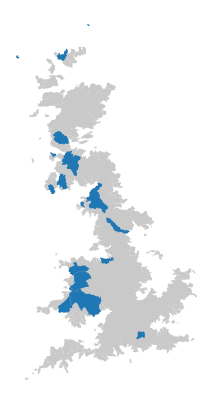

In [144]:
highlight_basin(basin_ids=ds_pos_nse.station_id.values)

### bottom basins (negative NSE)

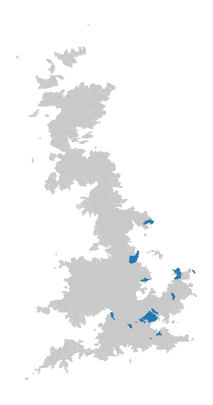

In [145]:
highlight_basin(basin_ids=ds_neg_nse.station_id.values)

### Is there a significant difference in variables for the best performing and worst performing models?
- H0 = there is no difference in **Var** between the groups (top performing NSE, worst performing NSE)
- H1 = there is a difference in **Var** between the groups (top performing NSE, worst performing NSE)

Use the **Wilcoxon signed-rank test**
- compare two related samples
- alternative to the paired Student's t-test for when diferences between samples not assumed to be Normally Distributed

In [147]:
from scipy.stats import wilcoxon
dyn_vars = ["precipitation", "pet", TARGET_VAR]

score_dict = dict()
for dyn_var in dyn_vars:
    vals = wilcoxon(ds_neg_nse[dyn_var].values.flatten(), ds_pos_nse[dyn_var].values.flatten())
    score_dict[dyn_var] = vals

In [148]:
score_dict

{'precipitation': WilcoxonResult(statistic=14782240058.0, pvalue=0.0),
 'pet': WilcoxonResult(statistic=22222796454.5, pvalue=0.0),
 'discharge_spec': WilcoxonResult(statistic=774440466.5, pvalue=0.0)}

## Because so many values better to just view histogram images?
- Note: probably better to just work with images/figures
- but more than 1mn values per histogram - takes too long?

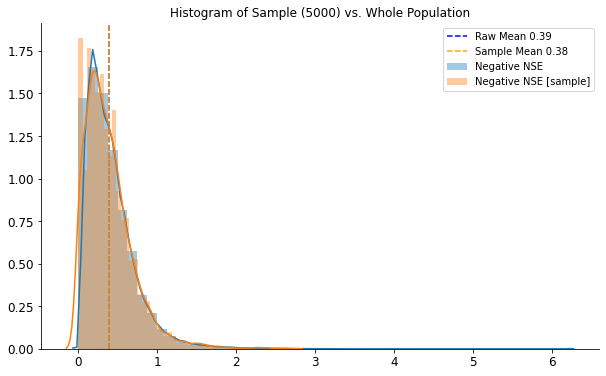

In [149]:
fig, ax = plt.subplots(figsize=(10, 6))
sample_size = 5000

raw = drop_nans_and_flatten(ds_neg_nse[dyn_var])
sample = np.random.choice(
    drop_nans_and_flatten(ds_neg_nse[dyn_var]), sample_size
)
sns.distplot(raw, ax=ax, label='Negative NSE', norm_hist=True)
sns.distplot(sample, ax=ax, label='Negative NSE [sample]', norm_hist=True)

ax.axvline(raw.mean(), color='blue', ls='--', label=f"Raw Mean {raw.mean():.2f}")
ax.axvline(sample.mean(), color='orange', ls='--', label=f"Sample Mean {sample.mean():.2f}")
ax.legend();
ax.set_title(f'Histogram of Sample ({sample_size}) vs. Whole Population')

# making the plot pretty
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

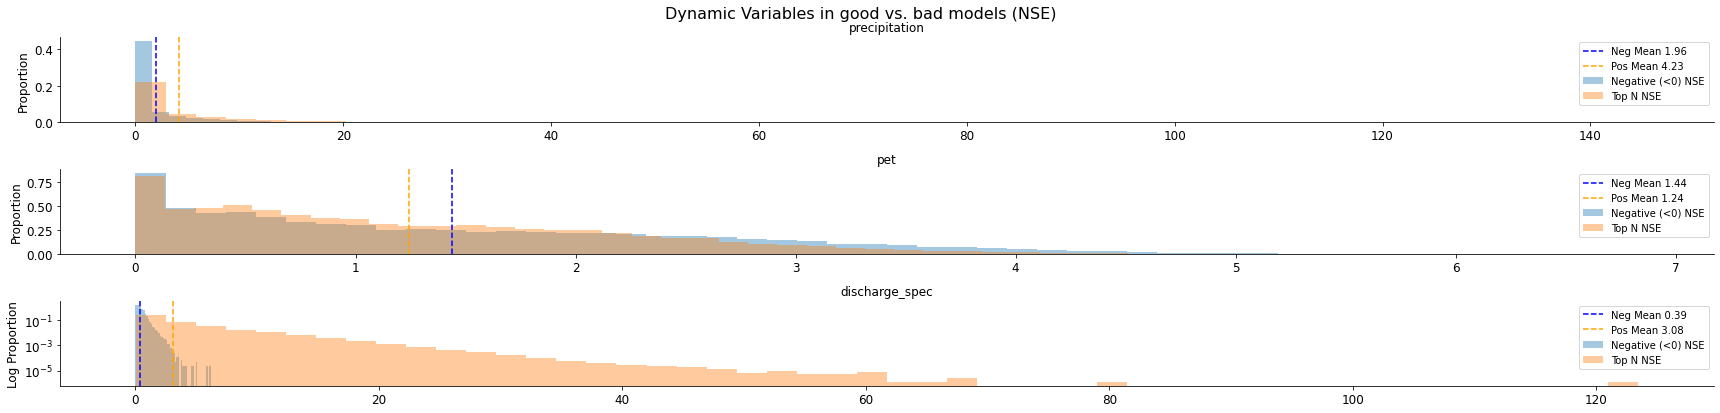

In [151]:
def plot_comparison_histogram(neg, pos, ax, title: str, logy: bool = False):
    # plot raw histogram
    sns.distplot(neg, ax=ax, label='Negative (<0) NSE', norm_hist=True, kde=False)
    sns.distplot(pos, ax=ax, label='Top N NSE', norm_hist=True, kde=False)
    
    # calculate & plot mean
    ax.axvline(neg.mean(), color='blue', ls='--', label=f"Neg Mean {neg.mean():.2f}")
    ax.axvline(pos.mean(), color='orange', ls='--', label=f"Pos Mean {pos.mean():.2f}")
    
    if logy:
        # ax.set_ylim(0, 0.01)
        ax.set_yscale('log')
        ax.set_ylabel('Log Proportion')
    else:
        ax.set_ylabel('Proportion')
    
    # 
    ax.set_title(title)
    
    # making the plot pretty
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                      + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.legend()
    
    return ax


fig, axs = plt.subplots(3, 1, figsize=(8*3, 6))

for ix, dyn_var in enumerate(dyn_vars):
    ax = axs[ix]
    neg = drop_nans_and_flatten(ds_neg_nse[dyn_var])
    pos = drop_nans_and_flatten(ds_pos_nse[dyn_var])
    
    logy = True if dyn_var == TARGET_VAR else False
    ax = plot_comparison_histogram(neg, pos, ax, title=dyn_var, logy=logy)
    
#     sns.distplot(neg, ax=ax, label='Negative (<0) NSE', norm_hist=True, kde=False)
#     sns.distplot(pos, ax=ax, label='Top N NSE', norm_hist=True, kde=False)

#     ax.axvline(neg.mean(), color='blue', ls='--', label=f"Neg Mean {neg.mean():.2f}")
#     ax.axvline(pos.mean(), color='orange', ls='--', label=f"Pos Mean {pos.mean():.2f}")
#     ax.legend();
#     ax.set_title(f'{dyn_var}')
    
#     if dyn_var == 'discharge_vol':
#         # ax.set_ylim(0, 0.01)
#         ax.set_yscale('log')
#         ax.set_ylabel('Log Proportion')
#     else:
#         ax.set_ylabel('Proportion')

#     # making the plot pretty
#     for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
#                       + ax.get_xticklabels() + ax.get_yticklabels()):
#             item.set_fontsize(12)

#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
    
suptitle = 'Dynamic Variables in good vs. bad models (NSE)'
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle(suptitle, size=16);

In [ ]:
# NOTE: produces +100 plots!
if False:
    static_vars = [v for v in static_neg_nse.data_vars]
    n_vars = len(static_vars)
    # fig, axs = plt.subplots(n_vars, 1, figsize=(8*n_vars, 6))

    log_vars = [None]

    for ix, static_var in enumerate(static_vars):
        # ax = axs[ix]
        fig, ax = plt.subplots(figsize=(8, 2))
        neg = drop_nans_and_flatten(static_neg_nse[static_var])
        pos = drop_nans_and_flatten(static_pos_nse[static_var])

        logy = True if static_var in log_vars else False
        ax = plot_comparison_histogram(neg, pos, ax, title=static_var, logy=logy)

In [ ]:
static_var = [v for v in static_neg_nse.data_vars][0]
fig, ax = plt.subplots()
neg = drop_nans_and_flatten(static_neg_nse[static_var])
pos = drop_nans_and_flatten(static_pos_nse[static_var])
ax = plot_comparison_histogram(neg, pos, ax, title=static_var, logy=logy)

-----------------
-----------------
-----------------
-----------------
-----------------
-----------------

# Marginalia

In [ ]:
xlim = [0, 60]
ylim = [0, 300]

fig, ax = plt.subplots()
sns.distplot(rmse_da.values, ax=ax, kde=False) #, bins=10)
ax.set_title('Distribution of RMSE for each Station')
ax.set_ylabel('# of Stations')
ax.set_xlabel('RMSE');
ax.axvline(rmse_da.mean(), ls=":", label=f'mean RMSE: {rmse_da.mean().values:.2f}')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.legend()

fig, ax = plt.subplots()
sns.distplot(rmse_time.values, ax=ax, kde=False, bins=100)
ax.set_title('Distribution of RMSE for each Time')
ax.set_ylabel('# of Timesteps')
ax.set_xlabel('RMSE');
ax.axvline(rmse_time.mean(), ls=":", label=f'mean RMSE: {rmse_time.mean().values:.2f}')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.legend()

In [ ]:
xlim = [0, 1.01]
ylim = [0, 250]

fig, ax = plt.subplots()
sns.distplot(drop_nans_and_flatten(nse_da), ax=ax, kde=False, bins=400)
ax.set_title('Distribution of NSE for each Station')
ax.set_ylabel('# of Stations')
ax.set_xlabel('NSE');
ax.axvline(nse_da.mean(), ls=":", label=f'mean NSE: {nse_da.mean().values:.2f}')
ax.set_xlim([-20, 1])
# ax.set_ylim(ylim)
plt.legend()

fig, ax = plt.subplots()
sns.distplot(drop_nans_and_flatten(nse_time), ax=ax, kde=False, bins=100)
ax.set_title('Distribution of NSE for each Time')
ax.set_ylabel('# of Timesteps')
ax.set_xlabel('NSE');
ax.axvline(nse_time.mean(), ls=":", label=f'mean NSE: {nse_time.mean().values:.2f}')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.legend()

In [ ]:
xlim = [0, 1.01]
ylim = [0, 250]

fig, ax = plt.subplots()
sns.distplot(r2_da.values, ax=ax, kde=False, bins=100)
ax.set_title('Distribution of R2 for each Station')
ax.set_ylabel('# of Stations')
ax.set_xlabel('R2');
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.axvline(r2_da.mean(), ls=":", label=f'mean R2: {r2_da.mean().values:.2f}')
plt.legend()


fig, ax = plt.subplots()
sns.distplot(r2_time.values, ax=ax, kde=False, bins=100)
ax.set_title('Distribution of R2 for each Time')
ax.set_ylabel('# of Timesteps')
ax.set_xlabel('R2');
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.axvline(r2_time.mean(), ls=":", label=f'mean R2: {r2_time.mean().values:.2f}')
plt.legend()


In [ ]:
fig, ax = plt.subplots()
rmse_time.plot(ax=ax)
ax.set_title('TimeSeries of Performance [RMSE]')

fig, ax = plt.subplots()
rmse_time.groupby('time.month').mean().plot(ax=ax)
ax.set_title('Seasonality of Performance [RMSE]')

fig, ax = plt.subplots()
rmse_time.resample(time='3M').mean().plot(ax=ax)
ax.set_title('Moving 3M Performance [RMSE]')

In [ ]:
fig, ax = plt.subplots()
nse_time.plot(ax=ax)
ax.set_title('TimeSeries of Performance [NSE]')

fig, ax = plt.subplots()
nse_time.groupby('time.month').mean().plot(ax=ax)
ax.set_title('Seasonality of Performance [NSE]')

fig, ax = plt.subplots()
nse_time.resample(time='3M').mean().plot(ax=ax)
ax.set_title('Moving 3M Performance [NSE]')

In [ ]:
fig, ax = plt.subplots()
r2_time.plot(ax=ax)
ax.set_title('TimeSeries of Performance [R2]')
ax.set_ylim(0, 1)

fig, ax = plt.subplots()
r2_time.groupby('time.month').mean().plot(ax=ax)
ax.set_title('Seasonality of Performance [R2]')

fig, ax = plt.subplots()
r2_time.resample(time='3M').mean().plot(ax=ax)
ax.set_title('Moving 3M Performance [R2]')


# Let's look at station 31023


In [ ]:
station_id = "31023"
station_df = df.query(f"station_id == '{station_id}'")

# floor values (if below 0 -> 0)
station_floored = station_df.copy()
station_floored.loc[station_floored.preds < 0, "preds"] = 0

In [ ]:
from src.analysis.evaluation import _r2_func, _rmse_func, _nse_func

_rmse_func(station_df.discharge_vol, station_df.preds, len(station_df))
_r2_func(station_df.discharge_vol, station_df.preds)
_nse_func(station_df.discharge_vol, station_df.preds)

In [ ]:
def pd_rmse(preds: pd.Series, obs: pd.Series) -> float:
    return ((obs - preds) ** 2).mean() ** .5

def pd_r2(preds: pd.Series, obs: pd.Series) -> float:
    return _r2_func

print(pd_rmse(station_df.preds, station_df.discharge_vol))
print(pd_rmse(station_floored.preds, station_df.discharge_vol))

### Raw values plotted

In [ ]:
fig, ax = plt.subplots()
station_df.plot(ax=ax);
rmse_val = _rmse_func(station_df.discharge_vol, station_df.preds, len(station_df))
r2_val = _r2_func(station_df.discharge_vol, station_df.preds)
nse_val = _nse_func(station_df.discharge_vol, station_df.preds)

ax.set_title(f"rmse: {rmse_val:.2f} r2: {r2_val:.2f} nse: {nse_val:.2f}");

### What happens if we set the values below 0 -> 0

In [ ]:
station_id = "31023"
station_df = df.query(f"station_id == '{station_id}'")
fig, ax = plt.subplots()
station_df.discharge_vol.plot(ax=ax);

# floor values
station_floored = station_df.copy()
station_floored.loc[station_floored.preds < 0, "preds"] = 0
station_floored.preds.plot(ax=ax)

rmse_val = _rmse_func(station_df.discharge_vol, station_floored.preds, len(station_df))
r2_val = _r2_func(station_df.discharge_vol, station_floored.preds)
nse_val = _nse_func(station_df.discharge_vol, station_floored.preds)

ax.set_title(f"rmse: {rmse_val:.2f} r2: {r2_val:.2f} nse: {nse_val:.2f}");

In [ ]:
# for ALL data
month_strs = [m for m in calendar.month_abbr]

fig, axs = plt.subplots(4, 3, figsize=(15, 6*4)) # , sharex=True, sharey=True, 
mth = 1

for mth in np.arange(1, 13):
    ax_ix = np.unravel_index(mth - 1, (4, 3))
    ax = axs[ax_ix]
    d = df[df.index.month == mth]

    ax.plot(d.discharge_vol, d.preds, 'kx', alpha=0.3, label='Data')

    # plot 1:1 line
    line_1_1_x = np.linspace(d.discharge_vol.min(), d.discharge_vol.max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')

    # get error metrics
    mean_metrics = metrics_time[metrics_time.time.dt.month == mth].mean()
    rmse = mean_metrics.loc['rmse']
    nse = mean_metrics.loc['nse']
    r2 = mean_metrics.loc['r2']

    # 
    title = f"{month_strs[mth]}\nRMSE: {rmse:.2f} R2: {r2:.2f} NSE: {nse:.2f}"
    ax.set_title(title)
    ax.legend()

    if ax_ix[0] == 3:
        ax.set_xlabel('Observed')
    if ax_ix[1] == 0:
        ax.set_ylabel('Predicted')